In [60]:
import sys
!{sys.executable} -m pip install --use-feature=2020-resolver --upgrade pip mappy pysam

In [63]:
import mappy as mp
import random
import re
import matplotlib.pylab as plt

In [8]:
def simulate_sequence(length):
    alphabet = ['A', 'C', 'G', 'T']
    
    bases = random.choices(alphabet, k=length)
    bases = ''.join(bases)
    
    return bases

In [9]:
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)

    return bases

In [10]:
def canonicalize_kmer(fw_kmer):
    rc_kmer = reverse_complement(fw_kmer)
    
    return fw_kmer if fw_kmer < rc_kmer else rc_kmer

In [11]:
def simulate_unsegmented_ccs_read(fw_seq, num_passes, ccs_fw_adapter, include_rc_adapter = False):
    rc_seq = reverse_complement(fw_seq)
    ccs_rc_adapter = reverse_complement(ccs_fw_adapter)
    
    subreads = []
    for i in range(num_passes):
        subreads.append(fw_seq if i % 2 == 0 else rc_seq)
        
        if i % 2 or include_rc_adapter:
            subreads.append(ccs_fw_adapter if i % 2 == 0 else ccs_rc_adapter)
        
    return subreads

In [12]:
def add_noise(seq, mismatch_rate=0, insertion_rate=0, deletion_rate=0):
    mm_positions = int(mismatch_rate*len(seq))
    ins_positions = int(insertion_rate*len(seq))
    del_positions = int(deletion_rate*len(seq))
    
    newseq = list(seq)
    
    for i in range(mm_positions):
        p = int(random.uniform(0, len(seq)))
        newseq[p] = reverse_complement(newseq[p])

    for i in range(ins_positions):
        p = int(random.uniform(0, len(seq)))
        l = int(random.uniform(2, 5))
        newseq[p] = l*newseq[p]
        
    for i in range(del_positions):
        p = int(random.uniform(0, len(seq)))
        newseq[p] = ''

    return ''.join(newseq)

In [91]:
random.seed(0)

fw_seq = simulate_sequence(1000)
ccs_adapter = "ATCTCTCTCAACAACAACAACGGAGGAGGAGGAAAAGAGAGAGAT"

noise_segment1 = simulate_sequence(20000)
noise_segment2 = simulate_sequence(5000)
segments = simulate_unsegmented_ccs_read(fw_seq, 10, ccs_adapter, include_rc_adapter=False)

polymerase_read = add_noise(noise_segment1 + ''.join(segments) + noise_segment2, mismatch_rate=0.03, deletion_rate=0.03, insertion_rate=0.03)

In [92]:
len(polymerase_read)

36292

In [93]:
f = open("tmp.fasta", "w")
f.write(f">1\n{polymerase_read}")
f.close()

In [94]:
!mummer -mum -b -c tmp.fasta tmp.fasta > tmp.mums

In [117]:
def read_mummer_mums_file(mums_file_path):
    """Reads the data from the mums file into a dictionary containing arrays of points.  
    Returns a dictionary containing forward and reverse hits.
    NOTE: Assumes only 1 sequence is in the mummers file with forward and reverse hits.
    """
    line_regex = re.compile(r'(\d+)\s+(\d+)\s+(\d+)')
    data = {"forward": [], "reverse": []}
    with open(mums_file_path, 'r') as f:
        name = None
        key = "forward"
        for line in f:
            # basic sanity check:
            if not name and line[0] != '>':
                    raise RuntimeError("Invalid file.  Mums entries must have sequence names (lines that start with '>') to start data blocks.")
            # Process the file:
            if line[0] == '>':
                name = line[1:].strip()
                if name.endswith(" Reverse"):
                    key = "reverse"
                    name = name[0:-8]
            else:
                m = line_regex.match(line.strip())
                x = int(m.group(1))
                y = int(m.group(2))
                l = int(m.group(3))
                data[key].append([x,y,l])
    return data, name

def plot_mummer_data(name, data):
    """Plots the data from a mummers file as read in by `read_mummers_mums_file`."""
    forward_handle = None
    reverse_handle = None
    
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    ax.set_aspect('equal', adjustable='box')
    
    # Plot Forward hits:
    for x,y,l in data['forward']:
        # Forward hits take the X and Y as point 1
        # For point 2, add L to both X and Y:
        plt.plot([x, x+l], [y, y+l], '.k', markersize=5)
        forward_handle, = plt.plot([x, x+l], [y, y+l], '-k', linewidth=2, label="Forward Alignments")
    # Plot reverse hits:
    for x,y,l in data['reverse']:
        # Reverse hits take the X and Y as point 1
        # For point 2, add L to X and subtract L from Y:
        reverse_handle, = plt.plot([x, x+l], [y, y-l], '.b', markersize=5, label="Reverse Alignments")
    return forward_handle, reverse_handle

(<matplotlib.lines.Line2D at 0x7f436813ba50>,
 <matplotlib.lines.Line2D at 0x7f4363f42ed0>)

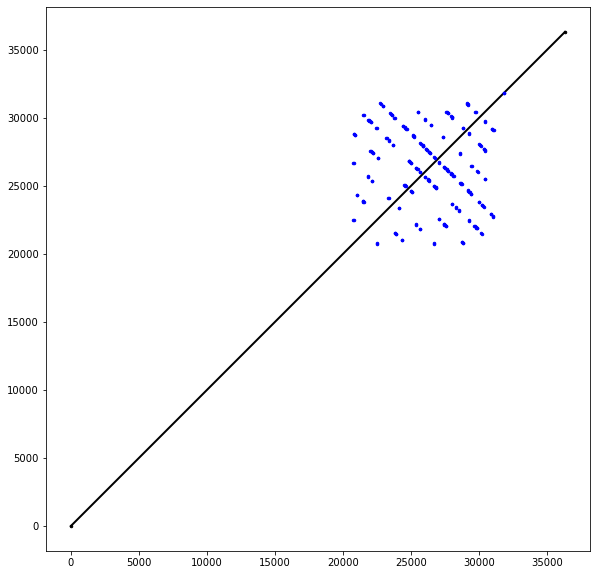

In [118]:
data, name = read_mummer_mums_file('tmp.mums')
plot_mummer_data(name, data)

In [85]:
data['reverse']

[[10307, 14418, 30],
 [10358, 16465, 30],
 [10419, 14302, 20],
 [10685, 14034, 22],
 [10728, 16087, 25],
 [10731, 18191, 29],
 [10816, 13897, 33],
 [10838, 11795, 22],
 [10864, 20180, 28],
 [10987, 13721, 28],
 [11162, 13564, 22],
 [11321, 17623, 23],
 [11350, 19703, 22],
 [11596, 19467, 25],
 [11774, 10859, 22],
 [11844, 19220, 28],
 [12106, 14719, 32],
 [12199, 16741, 21],
 [12323, 18714, 21],
 [12407, 16521, 29],
 [12589, 16336, 21],
 [12593, 14231, 23],
 [12764, 14057, 25],
 [12882, 20273, 29],
 [12922, 13898, 22],
 [13081, 20066, 26],
 [13132, 20015, 33],
 [13153, 13666, 23],
 [13236, 15686, 22],
 [13543, 11183, 22],
 [13644, 13175, 23],
 [13653, 19496, 20],
 [13694, 11014, 28],
 [13759, 19385, 20],
 [13865, 10848, 33],
 [13877, 12943, 22],
 [14011, 17015, 21],
 [14013, 10706, 22],
 [14033, 12788, 25],
 [14209, 12615, 23],
 [14232, 16796, 22],
 [14283, 10438, 20],
 [14389, 10336, 30],
 [14591, 18533, 21],
 [14592, 20663, 23],
 [14599, 16421, 21],
 [14688, 12137, 32],
 [14794, 1623